# GAN
## DCGAN 모델 구조 이용하여 CIFAR-10 데이터 생성
- 이미지 데이터의 shape가 (28, 28, 1)에서 (32, 32, 3)으로 변경
- 이미지가 단색의 grayscale에서 RGB 3채널의 컬러이미지로 변경
- 입력데이터 전체 차원이 3~4배 증가하면서, 학습이 진행되는 양상이 다소 달라짐
---
### 0. 작업환경 구성하기

In [1]:
! mkdir -p ~/aiffel/dcgan_newimage/cifar10/generated_samples
! mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_checkpoints
! mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_history

In [2]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

### 1. 데이터셋 구성하기
- CIFAR-10 데이터셋도 tf.keras안에 있는 datasets에 포함되어 있음   


- 학습에 사용할 train_x의 이미지를 [-1, 1]로 정규화합니다.
- 로드한 학습 데이터를 시각화를 통해 확인해 봅시다.
- tf.data.Dataset 모듈의 fromtensorslices() 함수를 사용하여 미니배치 데이터셋을 구성해 봅시다.


In [3]:
# 데이터셋 불러오기 : tf.keras안에 있는 datasets 꺼내기 
cifar10 = tf.keras.datasets.cifar10

# 라벨 분류 필요없음 : _ 로 해당되는 데이터는 무시한다.
(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

In [4]:
# 정규화

# Fashion MNIST 확인해보자 (0-255 사이의 픽셀값)
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

# -1, 1로 정규화 
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0
max pixel: 1.0
min pixel: -1.0


In [5]:
# 데이터셋 shape 확인 --  6만장 이미지가 28x28 사이즈

# CNN 채널 수 - 흑백은 1
train_x = train_x.reshape(train_x.shape[0], 32,32,3).astype('float32')
train_x.shape

(50000, 32, 32, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

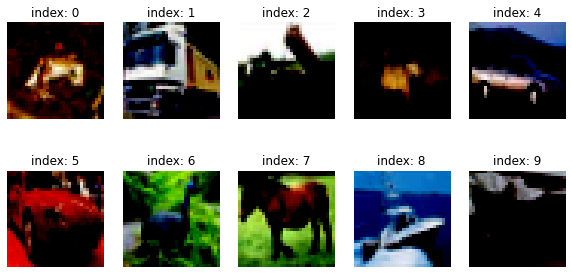

In [6]:
# 시각화
plt.figure(figsize=(10, 5))   # (10,5)는 이미지의 전체 프레임의 크기

# 여러 이미지 한번에 띄우기 plt.subplot(row, col, index)
for i in range(10):  
    plt.subplot(2, 5, i+1)  # 10개의 이미지를 2X5의 배열 형태
    plt.imshow(train_x[i].reshape(32,32,3))
    plt.title(f'index: {i}')   # 이미지 제목으로 라벨값 넣어줌
    plt.axis('off')    # 불필요한 '축' 지우기
plt.show()

In [7]:
BUFFER_SIZE = 50000   # 전체 데이터를 섞기 위해 50,000으로 설정 
BATCH_SIZE = 256  # 미니배치 학습 = (모델이 한번에 학습할 데이터양)

In [8]:
# from_tensor_slices() 함수를 이용하여 리스트,넘파이,텐서플로우 텐서자료형 데이터셋 만들 수 있다.
# train_x라는 넘파이 배열형 자료를 섞고 배치사이즈에 따라 나누기 
# 잘 섞이게 하기 위해 버퍼사이즈 >= 총 데이터 사이즈 

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### 2. 생성자 모델 구현하기
- (32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수 작성
- noise = tf.random.normal([1, 100])로 생성된 랜덤 노이즈를 입력으로 하여 방금 구현한 생성자로 랜덤 이미지를 생성
- 생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞는지 확인

In [9]:
# 생성자 생성 함수
def make_generator_model():

    # Start - 모델 시작하여 레이어 쌓기
    model = tf.keras.Sequential()  

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer - Conv2D와 반대로 이미지 사이즈 넓혀주는 층 
    # (8, 8, 256) → (16, 16, 64) → (32, 32, 1) 순으로 이미지를 키워나간다.
   
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())   # 신경망의 가중치가 폭발하지 않도록 가중치값을 정규화 시켜준다.
    model.add(layers.LeakyReLU()) # 활성화 함수

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh')) 
    # 활성화함수 tanh 사용 : -1 ~ 1 이내의 값으로 픽셀값을 정규화 시켰던 데이터셋과 동일하게 하기 위해

    return model

In [10]:
# 모델을 generator라는 변수로 생성 
generator = make_generator_model()
# 모델 세부 내용 summary 출력
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

Non_trainable params????????????

In [11]:
# shape=(1, 100)의 형상을 가지는 랜덤 노이즈 벡터를 생성
# tf.random.normal을 이용하면 가우시안 분포에서 뽑아낸 랜덤 벡터로 이루어진 노이즈 벡터를 만들 수 있다.

noise = tf.random.normal([1, 100])

In [12]:
# [1, 32,32, 1] 사이즈 이미지 생성됨
# 1 : batch_size = 1, (32,32,3) 사이즈 이미지 생성 되었다는 뜻

generated_image = generator(noise, training=False) # 학습 중이 아니다.
generated_image.shape

TensorShape([1, 32, 32, 3])

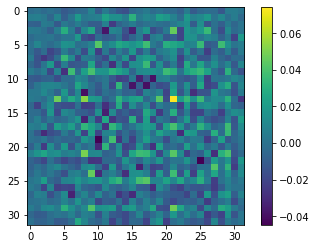

In [13]:
# 이미지 시각화 
# matplotlib는 2차원 이미지만 볼 수 있으므로, 0,3번째 축 인덱스를 0으로 설정
plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()
# 아직 모델 학습 전이라 노이즈가 보인다. 

### 3. 판별자 모델 구현하기
- (32, 32, 3)의 이미지를 입력으로 받아 1dim을 판별결과를 출력하는 판별자 모델 구현 함수를 작성해 봅시다.
- 위 STEP 2에서 생성한 랜덤 이미지를 판별자 모델이 판별한 결과값을 확인해 봅시다.


In [14]:
# 판별자 함수 구현
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer - 이미지의 크기를 줄여나간다.
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer - 3차원-> 1차원으로 펴서 8x8x128=8192, 즉 (1, 8192) 형상의 벡터로 변환
    # Reshape 층에서 1차원-> 3차원으로 변환했던 것과 반대 역할 
    model.add(layers.Flatten())

    # Fourth: Dense Layer - 단 하나의 값으로 출력
    model.add(layers.Dense(1))

    return model

In [15]:
# 모델 변수로 생성
discriminator = make_discriminator_model()
# 모델 세부 내용 출력
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

In [16]:
# 만약 가짜 이미지는 판별자에 입력 시키면 ?
decision = discriminator(generated_image, training=False)
decision
# 텐서플로우의 텐서 형태로 출력 - 아무 의미 없음 ~

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.0061404]], dtype=float32)>

### 4. 손실함수와 최적화 함수 구현하기
- 생성자와 판별자의 손실함수(loss)를 구현
- 판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 함수 구현
- 생성자와 판별자를 최적화하는 optimizer를 정의

In [17]:
## 손실함수 구하기
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [18]:
# 생성자 Loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [19]:
# 판별자 Loss - 2가지 모두 구한 후 더한 값
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [20]:
# 판별자 Accuracy
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [21]:
# 최적화 함수 구하기
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [22]:
# 생성자가 생성한 샘플 확인 - 16장
# 생성할 샘플은 매번 같은 노이즈(고정된 seed 노이즈) 로 생성해야 과정 확인 가능

noise_dim = 100 # 100차원 노이즈를 총 16개 
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

### 5. 훈련과정 상세 기능 구현하기
- 1개 미니배치의 훈련 과정을 처리하는 train_step() 함수를 구현
- 16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 generate_and_save_images() 함수 구현
- 훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화하는 draw_train_history() 함수 구현
- training_checkpoints 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈을 설정

In [23]:
# 1개 미니배치 훈련 과정을 처리하는 train_step 함수 구현 

@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [24]:
# 한단계씩 train_step을 일정 간격으로 학습 현황 볼 수 있는 함수

def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [25]:
# 시각화를 위한 그래프 생성

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [26]:
# epoch마다 모델을 저장하는 checkpoint 모듈을 설정

checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)



### 6. 학습 과정 진행하기
- 위 STEP 5에서 구현한 기능들을 활용하여 최소 50 epoch만큼의 모델 학습을 진행
- 학습 과정에서 생성된 샘플 이미지로 만든 gif 파일을 통해 학습 진행 과정을 시각적으로 표현
- 학습 과정을 담은 샘플 이미지, gif 파일, 학습 진행 그래프 이미지를 함께 제출

In [27]:
# 모델 학습 과정 합치기 

def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [30]:
save_every = 5
EPOCHS = 500

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

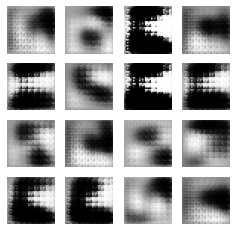

Epoch 6 | iter 51
Time for epoch 6 : 3 sec


In [ ]:
%%time
train(train_dataset, EPOCHS, save_every)


# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/cifar-10/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

In [ ]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.


## 루브릭 평가

1. GAN의 두 모델 구조를 통해 이미지를 성공적으로 생성하였다.오브젝트 종류를 육안으로 구별할 수 있을 만한 이미지를 생성하였다.
-   

2. 생성 이미지 시각화 및 학습 그래프를 통해 GAN 학습이 바르게 진행되었음을 입증하였다.gif를 통해 생성이미지 품질이 서서히 향상되는 것과, fake accuracy가 추세적으로 0.5를 향해 하향하고 있음을 확인하였다.
- 
  
3. 추가적인 GAN 모델구조 혹은 학습과정 개선 아이디어를 제안하고 이를 적용하였다.
- 


## 회고  
  
  ---
  저번 프로젝트때 부터 모델 학습 시간이 너무 오래 걸려서 힘들다. 몇시간 동안 컴퓨터로 학습을 돌렸는데, 하이퍼파라미터를 수정하려고 하면 다시 학습을 시키려니 엄두가 나지 않았다. 얼핏 들었던 GAN에 대하여 직접 프로젝트를 구성해보고 공부하니 흥미로웠다. 더 좋은 성능을 만들어내지 못하는 한계에 너무 아쉬웠다. 계속해서 수정하고 학습만 돌려 놓고 완성해 볼 생각이다. epoch를 몇백, 몇 천으로 나타내야 그나마 괜찮은 결과가 나타난다고 하는데 과연 할 수 있을까? 아이펠 노트북을 반납하면 어떤 노트북으로 공부를 해야할지 고민이다. 맥북을 사고 시..ㅍ..다 ...ㅎ